In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [5]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [6]:
train_path = 'C:/Users/Anastasia/Downloads/mask_detection/data/Train'
test_path = 'C:/Users/Anastasia/Downloads/mask_detection/data/Test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 6809 images belonging to 2 classes.
Found 744 images belonging to 2 classes.


In [7]:
# test if all images are fine
import os
from PIL import Image
extensions = []
for fldr in os.listdir(test_path):
    sub_folder_path = os.path.join(train_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        try:
            im = Image.open(file_path)
            rgb_im = im.convert('RGB')
            if filee.split('.')[1] not in extensions:
                extensions.append(filee.split('.')[1])
        except:
            os.remove(file_path)

C:\Users\Anastasia\anaconda3\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [9]:
x = mobile.layers[-6].output

In [10]:
output = Dense(units=2, activation='softmax')(x)

In [11]:
model = Model(inputs=mobile.input, outputs=output)

In [12]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [13]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            epochs=20,
            verbose=2
)

Epoch 1/20
681/681 - 17s - loss: 0.0016 - accuracy: 0.9994
Epoch 2/20
681/681 - 17s - loss: 3.8809e-04 - accuracy: 1.0000
Epoch 3/20
681/681 - 17s - loss: 3.3428e-04 - accuracy: 1.0000
Epoch 4/20
681/681 - 17s - loss: 8.4364e-04 - accuracy: 0.9999
Epoch 5/20
681/681 - 18s - loss: 2.0910e-04 - accuracy: 1.0000
Epoch 6/20
681/681 - 17s - loss: 1.9718e-04 - accuracy: 1.0000
Epoch 7/20
681/681 - 17s - loss: 3.0989e-05 - accuracy: 1.0000
Epoch 8/20
681/681 - 17s - loss: 4.1193e-04 - accuracy: 0.9999
Epoch 9/20
681/681 - 17s - loss: 0.0035 - accuracy: 0.9990
Epoch 10/20
681/681 - 17s - loss: 0.0012 - accuracy: 0.9997
Epoch 11/20
681/681 - 18s - loss: 2.6841e-04 - accuracy: 1.0000
Epoch 12/20
681/681 - 18s - loss: 7.0238e-04 - accuracy: 0.9997
Epoch 13/20
681/681 - 18s - loss: 6.6763e-04 - accuracy: 0.9997
Epoch 14/20
681/681 - 17s - loss: 1.0816e-04 - accuracy: 1.0000
Epoch 15/20
681/681 - 17s - loss: 2.9013e-05 - accuracy: 1.0000
Epoch 16/20
681/681 - 17s - loss: 2.7463e-05 - accuracy: 1.00

In [16]:
test_labels = test_batches.classes

In [17]:
model=load_model("mask_detection_binary_v6-surgical.h5")

OSError: SavedModel file does not exist at: mask_detection_binary_v6-surgical.h5/{saved_model.pbtxt|saved_model.pb}

In [18]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [19]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[372   0]
 [  1 371]]


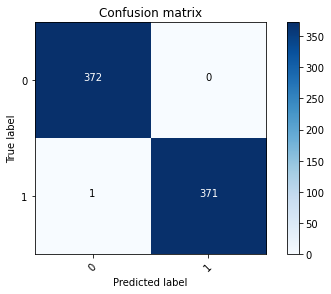

In [21]:
plot_confusion_matrix(cm = cm, classes = ["0","1"],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [22]:
test_batches.class_indices

{'with_mask': 0, 'without_mask': 1}

In [23]:
model.save("mask_detection_binary_v6-surgical.h5")

In [24]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model=load_model("mask_detection_binary_v6-surgical.h5")

labels_dict={0:'mask', 1:'without mask'}
color_dict={0:(0, 255, 0),1:(0,0,255)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('C:/Users/Anastasia/Downloads/mask_detection/haarcascade_frontalface_default.xml')
while True:
    rval, im = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror
    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))
    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(150,150))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        #print(result)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()